In [15]:
import argparse
import os
from pathlib import Path
import torch
import torch.nn as nn
from PIL import Image
from os.path import basename
from os.path import splitext
from torchvision import transforms
from torchvision.utils import save_image

%load_ext autoreload
%autoreload 2
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import tensorflow.keras as keras
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from operator import itemgetter
def print_public_attributes(obj):
    print(list([att for att in dir(obj) 
         if '__' not in att and not att.startswith('_')]))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def flatten(tensor, dim):
    shape = tf.shape(tensor)
    new_shape = tf.concat([shape[:dim], tf.reduce_prod(shape[dim:],keepdims=True)], axis=0)
    tensor = tf.reshape(tensor,new_shape)
    return tensor
flatten(tf.ones((1,2,3,4)),2)

<tf.Tensor: shape=(1, 2, 12), dtype=float32, numpy=
array([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], dtype=float32)>

In [17]:
def transpose_channels_first(tensor):
    return tf.transpose(tensor,[0,3,1,2])
def transpose_channels_last(tensor):
    return tf.transpose(tensor,[0,2,3,1])
assert transpose_channels_last(
    transpose_channels_first(
        tf.ones([2,3,4,5])
    )
).shape == [2,3,4,5]

In [18]:
def calc_mean_std_pt(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2] # N,C,H,W
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def calc_mean_std_tf(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    feat_mean, feat_var = tf.nn.moments(feat,[2,3],keepdims=True,)
    shape = tf.shape(feat)
    bessel_correction = tf.cast(shape[2] * shape[3] / (shape[2] * shape[3] - 1), tf.float32)
#     feat_flat = tf.reshape(feat,[shape[0],shape[1], shape[2] * shape[3]])
#     feat_mean = tf.reduce_mean(feat_flat,[2],keepdims=True)
#     feat_var = tf.math.reduce_variance(feat_flat,[2],keepdims=True) * bessel_correction + eps
    feat_std = tf.sqrt(feat_var * bessel_correction + eps) 
#     feat_ += eps
#     feat_std = tf.sqrt(feat_var)
    return feat_mean, feat_std

with torch.no_grad():
    inval_pt = np.arange(24,dtype='float32').reshape(1,4,2,3)
    exp = calc_mean_std_pt(
        torch.tensor(inval_pt)
    )
    inval_tf = np.arange(24,dtype='float32').reshape(1,4,2,3)
    act = calc_mean_std_tf(
        tf.constant(inval_tf)
    )
    for a,b in zip(exp,act):
        assert np.allclose(a.numpy(),b.numpy())

In [19]:
a,b

(tensor([[[[1.8708]],
 
          [[1.8708]],
 
          [[1.8708]],
 
          [[1.8708]]]]),
 <tf.Tensor: shape=(1, 4, 1, 1), dtype=float32, numpy=
 array([[[[1.8708315]],
 
         [[1.8708315]],
 
         [[1.8708315]],
 
         [[1.8708315]]]], dtype=float32)>)

In [20]:
exp[0].shape,act[0].shape

(torch.Size([1, 4, 1, 1]), TensorShape([1, 4, 1, 1]))

In [21]:
exp, act

((tensor([[[[ 2.5000]],
  
           [[ 8.5000]],
  
           [[14.5000]],
  
           [[20.5000]]]]),
  tensor([[[[1.8708]],
  
           [[1.8708]],
  
           [[1.8708]],
  
           [[1.8708]]]])),
 (<tf.Tensor: shape=(1, 4, 1, 1), dtype=float32, numpy=
  array([[[[ 2.5]],
  
          [[ 8.5]],
  
          [[14.5]],
  
          [[20.5]]]], dtype=float32)>,
  <tf.Tensor: shape=(1, 4, 1, 1), dtype=float32, numpy=
  array([[[[1.8708315]],
  
          [[1.8708315]],
  
          [[1.8708315]],
  
          [[1.8708315]]]], dtype=float32)>))

In [22]:
def mean_variance_norm_pt(feat):
    size = feat.size()
    mean, std = calc_mean_std_pt(feat)
    normalized_feat = (feat - mean.expand(size)) / std.expand(size)
    return normalized_feat

def mean_variance_norm_tf(feat):
    shape = tf.shape(feat)
    mean, std = calc_mean_std_tf(feat)
    normalized_feat = (feat - tf.broadcast_to(mean,shape)) \
        / tf.broadcast_to(std,shape)
    return normalized_feat

with torch.no_grad():
    inval = np.arange(24,dtype='float32').reshape(1,2,3,4)
    exp = mean_variance_norm_pt(
        torch.tensor(inval)
    )
    act = mean_variance_norm_tf(
        tf.constant(inval)
    )
    assert np.allclose(exp.numpy(),act.numpy())

In [23]:
from tensorflow.keras.applications import efficientnet

In [24]:
enet = efficientnet.EfficientNetB0(False,input_shape=(512,512,3))
enet.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
____________________

In [25]:
vggnet = tf.keras.applications.vgg19.VGG19(False, input_shape=(512,512,3))
vggnet.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
______________________________________________________________

In [26]:
%%timeit
vggnet(tf.random.normal((1,512,512,3))).shape

1.77 s ± 92.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%timeit
enet(tf.random.normal((1,512,512,3))).shape

285 ms ± 5.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
class ReflectionPadding2D(tf.keras.layers.Layer):
    '''
    
    '''
    def __init__(self,paddings,data_format='channels_last'):
        super().__init__()
        assert data_format in ['channels_first','channels_last']
        self.channels_first = data_format == 'channels_first'
        assert len(tf.shape(paddings)) == 2
        assert tf.shape(paddings)[1] == 2
        self.paddings = tf.constant(paddings)
    def call(self, inputs):
        assert len(tf.shape(inputs)) == 4
        if self.channels_first:
            inputs = transpose_channels_last(inputs)
        result = tf.pad(inputs, 
                      self.paddings,
                      mode='REFLECT',
                      name=None)
        if self.channels_first:
            result = transpose_channels_first(result)
        return result
ReflectionPadding2D(
    [[0,0],[1,1],[1,1],[0,0]],
    'channels_first'
)(tf.random.normal((1,4,4,3)))

<tf.Tensor: shape=(1, 4, 6, 5), dtype=float32, numpy=
array([[[[-1.5594683 , -0.32614532, -1.5594683 , -1.7911544 ,
          -1.5594683 ],
         [ 1.1233152 ,  0.5091859 ,  1.1233152 , -1.5077542 ,
           1.1233152 ],
         [-1.5594683 , -0.32614532, -1.5594683 , -1.7911544 ,
          -1.5594683 ],
         [ 0.72146606, -0.64444655,  0.72146606, -0.29029083,
           0.72146606],
         [-0.85405046, -1.2006383 , -0.85405046, -1.6445185 ,
          -0.85405046],
         [ 0.72146606, -0.64444655,  0.72146606, -0.29029083,
           0.72146606]],

        [[-0.24999072, -0.29598314, -0.24999072, -1.4969165 ,
          -0.24999072],
         [-0.26399195,  0.26557106, -0.26399195, -0.8724568 ,
          -0.26399195],
         [-0.24999072, -0.29598314, -0.24999072, -1.4969165 ,
          -0.24999072],
         [ 0.5145201 , -0.12669025,  0.5145201 , -2.0244412 ,
           0.5145201 ],
         [-3.0541656 ,  0.37773457, -3.0541656 ,  0.42212567,
          -3.0541656 ]

In [105]:
dec_arch = [
    ['refpad',[1,1,1,1]],
    ['conv',[512,256,(3,3)]],
    ['relu'],
    ['upsample',2],
    
    ['refpad',[1,1,1,1]],
    ['conv',[256,256,(3,3)]],
    ['relu'],
    ['refpad',[1,1,1,1]],
    ['conv',[256,256,(3,3)]],
    ['relu'],
    ['refpad',[1,1,1,1]],
    ['conv',[256,256,(3,3)]],
    ['relu'],
    ['refpad',[1,1,1,1]],
    ['conv',[256,128,(3,3)]],
    ['relu'],    
    ['upsample',2],
    
    
    ['refpad',[1,1,1,1]],
    ['conv',[128,128,(3,3)]],
    ['relu'],    
    ['refpad',[1,1,1,1]],
    ['conv',[128,64,(3,3)]],
    ['relu'],    
    ['upsample',2],
    
    ['refpad',[1,1,1,1]],
    ['conv',[64,64,(3,3)]],
    ['relu'],    
    ['refpad',[1,1,1,1]],
    ['conv',[64,3,(3,3)]],
    ['upsample',2]
]

def make_encoder():
    enet = efficientnet.EfficientNetB0(False,input_shape=(None, None,3))
#     inputs = tf.keras.Input(shape=(None,None,3))
#     output = enet(inputs)
    output_1 = enet.get_layer('block5a_activation').output
    output_2 = enet.get_layer('block6a_activation').output
    
    encoder = tf.keras.Model(inputs=enet.inputs,
                             outputs={'enc_a':output_1,'enc_b':output_2})
    encoder.trainable = False
    assert encoder(tf.random.normal((2,512,512,3))) is not None
    return encoder


def make_decoder(in_channels=512):
    inputs = tf.keras.Input(shape=(None,None,in_channels))
    outputs = inputs
    for layer_info in dec_arch:
        if layer_info[0] == 'relu':
            outputs = tf.keras.layers.ReLU()(outputs)
        elif layer_info[0] == 'conv':
            _,[inc,outc,[kw,kh]] = layer_info
            outputs = tf.keras.layers.Conv2D(outc,kernel_size=(kw,kh))(outputs)
        elif layer_info[0] == 'refpad':
            _,pad_size = layer_info
            # outputs = [NB, W, H, C] -> Pads = [4, 2]
#             outputs = tf.pad(outputs,  paddings=[[0,0],[1,1],[1,1],[0,0]], mode='REFLECT', )
            outputs = ReflectionPadding2D(paddings=[[0,0],[1,1],[1,1],[0,0]],
                                           data_format='channels_last')(outputs)
        elif layer_info[0] == 'upsample':
            _,factor = layer_info
            outputs = tf.keras.layers.UpSampling2D(size=(factor,factor))(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    assert model(tf.random.normal((1,16,16,in_channels))) is not None
    return model
encoder = make_encoder()

# decoder = make_decoder()

In [69]:
for k,v in encoder(tf.random.normal((1,512,512,3))).items():
    print(k,v.shape)

enc_a (1, 32, 32, 480)
enc_b (1, 16, 16, 672)


In [70]:
def make_decoder(in_channels=512):
    inputs = tf.keras.Input(shape=(None,None,in_channels))
    outputs = inputs
    for layer_info in dec_arch:
        if layer_info[0] == 'relu':
            outputs = tf.keras.layers.ReLU()(outputs)
        elif layer_info[0] == 'conv':
            _,[inc,outc,[kw,kh]] = layer_info
            outputs = tf.keras.layers.Conv2D(outc,kernel_size=(kw,kh))(outputs)
        elif layer_info[0] == 'refpad':
            _,pad_size = layer_info
            # outputs = [NB, W, H, C] -> Pads = [4, 2]
#             outputs = tf.pad(outputs,  paddings=[[0,0],[1,1],[1,1],[0,0]], mode='REFLECT', )
            outputs = ReflectionPadding2D(paddings=[[0,0],[1,1],[1,1],[0,0]],
                                           data_format='channels_last')(outputs)
        elif layer_info[0] == 'upsample':
            _,factor = layer_info
            outputs = tf.keras.layers.UpSampling2D(size=(factor,factor))(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    assert model(tf.random.normal((1,16,16,512))) is not None
    return model

make_decoder()(tf.random.normal((1,32,32,512))).shape

TensorShape([1, 512, 512, 3])

In [30]:
%%timeit
encoder(tf.random.normal((1,512,512,3))).items()

231 ms ± 7.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%%timeit
decoder(tf.random.normal((2,16,16,512))).shape

179 ms ± 3.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
# encoder.summary()

In [33]:
# filter_height, filter_width, in_channels, out_channels
# x = tf.ones((1,2,4,5),'float32')
# z = tf.ones((1,4,2,3))
# y = tf.nn.conv2d(z,x,1,'VALID','NCHW')
# y.shape

class ChannelsFirstConv2D(tf.keras.layers.Conv2D):
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
    def __call__(self,inputs):
        # inputs : [BN, C, H, W]
        inputs = transpose_channels_last(inputs)
        # inputs : [BN, H, W, C]
        result = super().__call__(inputs)
        # result : [BN, H, W, conv_filters]
        result = transpose_channels_first(result)
        # result : [BN, conv_filters, H, W]
        return result
    
x = ChannelsFirstConv2D(3,kernel_size=1)
x(tf.random.normal((1,4,2,2))).shape

TensorShape([1, 3, 2, 2])

In [34]:

class SANet_pt(nn.Module):
    def __init__(self, in_planes):
        super().__init__()
        self.f = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.g = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.h = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.sm = nn.Softmax(dim = -1)
        self.out_conv = nn.Conv2d(in_planes, in_planes, (1, 1))
        
    def forward(self, content, style):
        content = torch.tensor(content)
        style = torch.tensor(style)

        F = self.f(mean_variance_norm_pt(content))
        G = self.g(mean_variance_norm_pt(style))
        H = self.h(style)
        b, c, h, w = F.size()
        F = F.view(b, -1, w * h).permute(0, 2, 1)
        b, c, h, w = G.size()
        G = G.view(b, -1, w * h)
        S = torch.bmm(F, G)
        S = self.sm(S)
        b, c, h, w = H.size()
        H = H.view(b, -1, w * h)
        O = torch.bmm(H, S.permute(0, 2, 1))
        b, c, h, w = content.size()
        O = O.view(b, c, h, w)
        O = self.out_conv(O)
        O += content
        return O
    
class SANet_tf(tf.keras.Model):
    '''
    Expects and outputs channels first inputs of size [BN,C,H,W]
    '''
    def __init__(self, in_planes):
        super().__init__()
        self.f = ChannelsFirstConv2D(in_planes, kernel_size=1)
        self.g = ChannelsFirstConv2D(in_planes, kernel_size=1)
        self.h = ChannelsFirstConv2D(in_planes, kernel_size=1)
        self.sm = tf.keras.layers.Softmax(axis=-1)
        self.out_conv = ChannelsFirstConv2D(in_planes,kernel_size=1)
#         self.f = nn.Conv2d(in_planes, in_planes, (1, 1))
#         self.g = nn.Conv2d(in_planes, in_planes, (1, 1))
#         self.h = nn.Conv2d(in_planes, in_planes, (1, 1))
#         self.sm = nn.Softmax(dim = -1)
#         self.out_conv = nn.Conv2d(in_planes, in_planes, (1, 1))
        
    def call(self, content, style):
        content = tf.constant(content)
        style = tf.constant(style)
        
        F = self.f(mean_variance_norm_tf(content))
        G = self.g(mean_variance_norm_tf(style))
        H = self.h(style)
        
        # b, c, h, w = F.size()
        # F = F.view(F.size(0), -1, F.size(2) * F.size(3)).permute(0, 2, 1)
        
        ## F = torch.flatten(F, 2).permute(0,2,1)
        shape = tf.shape(F)
        F = tf.reshape(F,[shape[0],shape[1],shape[2] * shape[3]])
        F = tf.transpose(F, [0,2,1])
        
        # b, c, h, w = G.size()
        
        # G = G.view(G.size(0), -1, G.size(2) * G.size(3))
#         G = torch.flatten(G, 2)
        shape = tf.shape(G)
        G = tf.reshape(G,[shape[0],shape[1], shape[2] * shape[3]])
        
#         S = torch.bmm(F, G)
        S = tf.matmul(F,G)
#         # S = torch.einsum('bijc,bklc->bijkl', F, G)
        S = self.sm(S)

#         # b, c, h, w = H.size()
#         # H = H.view(H.size(0), -1, H.size(2) * H.size(3))
#         H = torch.flatten(H, 2)

        shape = tf.shape(H)
        H = tf.reshape(H,[shape[0],shape[1],shape[2] * shape[3]])
        
#         O = torch.bmm(H, S.permute(0, 2, 1))
        O = tf.matmul(H, tf.transpose(S,[0,2,1]))
    
#         b, c, h, w = content.size()
        shape = tf.shape(content)
#         O = O.view(b, c, h, w)
        O = tf.reshape(H,shape)
        O = self.out_conv(O)
        O += content
        return O
#         return content

with torch.no_grad():
    sanet_pt = SANet_pt(4)
    sanet_tf = SANet_tf(4)
    inc_pt,ins_pt = np.arange(16 * 3,dtype='float32').reshape(2,1,4,2,3)
    exp = sanet_pt(inc_pt,ins_pt)
    inc,ins = np.arange(16 * 3,dtype='float32').reshape(2,1,4,2,3)
    act = sanet_tf(inc,ins)
    print(exp.shape, act.shape)
    assert np.allclose(exp.shape, act.shape)
#     assert np.allclose(exp, act)

torch.Size([1, 4, 2, 3]) (1, 4, 2, 3)


In [35]:
exp, act

(tensor([[[[15.2425, 16.4059, 17.6601],
           [18.9879, 20.3064, 21.5423]],
 
          [[-9.4631, -8.6117, -7.8430],
           [-7.1412, -6.4309, -5.6455]],
 
          [[13.1202, 14.1354, 15.1592],
           [16.1898, 17.2195, 18.2415]],
 
          [[25.3389, 26.4530, 27.6305],
           [28.8594, 30.0818, 31.2465]]]]),
 <tf.Tensor: shape=(1, 4, 2, 3), dtype=float32, numpy=
 array([[[[ 21.442556,  22.95801 ,  24.473463],
          [ 25.988922,  27.504377,  29.019836]],
 
         [[-20.14466 , -20.017586, -19.890512],
          [-19.763443, -19.636372, -19.5093  ]],
 
         [[-38.885956, -39.416702, -39.94745 ],
          [-40.478203, -41.008957, -41.53971 ]],
 
         [[ 62.506725,  64.92831 ,  67.3499  ],
          [ 69.77149 ,  72.193085,  74.61467 ]]]], dtype=float32)>)

In [89]:

class Transform_pt(nn.Module):
    def __init__(self, in_planes):
        super().__init__()
        self.sanet4_1 = SANet_pt(in_planes = in_planes)
        self.sanet5_1 = SANet_pt(in_planes = in_planes)
        self.upsample5_1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.merge_conv_pad = nn.ReflectionPad2d((1, 1, 1, 1))
        self.merge_conv = nn.Conv2d(in_planes, in_planes, (3, 3))
    def forward(self, content4_1, style4_1, content5_1, style5_1):
        
        s4_1 = self.sanet4_1(content4_1, style4_1) 
        s5_1 = self.sanet5_1(content5_1, style5_1)
        print('s4',s4_1.shape, 's5', s5_1.shape)
        s5_1_2up = self.upsample5_1(s5_1)
        added = s4_1 + s5_1_2up
        merged = self.merge_conv_pad(added)
        print('merged',merged.shape)
        res = self.merge_conv(merged) 
        print('res',res.shape)
        return res
#         return self.merge_conv(self.merge_conv_pad(self.sanet4_1(content4_1, style4_1) + self.upsample5_1(self.sanet5_1(content5_1, style5_1))))


class Transform_tf(tf.keras.Model):    
    def __init__(self, in_planes):
        super().__init__()
        
        self.same_planes = in_planes[0] == in_planes[1]
        in_planes = in_planes[0]
        
        self.sanet4_1 = SANet_tf(in_planes = in_planes)
        self.sanet5_1 = SANet_tf(in_planes = in_planes)
        
        self.conv_same_planes_c = tf.keras.Sequential([
            tf.keras.layers.Conv2D(in_planes,1),
            tf.keras.layers.BatchNormalization(),
        ])
        
        self.conv_same_planes_s = tf.keras.Sequential([
            tf.keras.layers.Conv2D(in_planes,1),
            tf.keras.layers.BatchNormalization(),
        ])
        
        self.upsample5_1 = keras.layers.UpSampling2D(2, interpolation='nearest', 
                                                     data_format='channels_first')
        self.merge_conv_pad = ReflectionPadding2D([[0,0],[1,1],[1,1],[0,0]],data_format='channels_first')
        self.merge_conv = ChannelsFirstConv2D(in_planes, (3, 3))
        
    def call(self, content4_1, style4_1, content5_1, style5_1):
        # inputs are channels_last
        
        # Make same planes if different
        if not self.same_planes:
            content5_1 = self.conv_same_planes_c(content5_1)
            style5_1 = self.conv_same_planes_s(style5_1)
            
        # convert to channels first
        content4_1 = transpose_channels_first(content4_1)
        style4_1 = transpose_channels_first(style4_1)
        content5_1 = transpose_channels_first(content5_1)
        style5_1 = transpose_channels_first(style5_1)

        # perform transform
        s4_1 = self.sanet4_1(content4_1, style4_1) 
        s5_1 = self.sanet5_1(content5_1, style5_1)
        print('s4',s4_1.shape, 's5', s5_1.shape)
        s5_1_2up = self.upsample5_1(s5_1)
        added = s4_1 + s5_1_2up
        merged = self.merge_conv_pad(added)
        print('merged',merged.shape)

        channels_first_result = self.merge_conv(merged) 
        print('res',channels_first_result.shape)
        
        # outputs are channels_last
        return transpose_channels_last(channels_first_result)

def arange_of_shape(*shape,dtype='float32'):
    return np.arange(np.prod(shape),dtype=dtype).reshape(*shape)

with torch.no_grad():
    trf_pt = Transform_pt(4)
    trf_tf = Transform_tf([4,4])
    inc_pt,ins_pt = torch.tensor(
        arange_of_shape(2,1,4,4,4)
    )
    inc5_pt,ins5_pt = torch.tensor(
        arange_of_shape(2,1,4,2,2)
    )
    exp = trf_pt(
        inc_pt,ins_pt,
        inc5_pt,ins5_pt
    )
    inc_tf,ins_tf = tf.constant(
        arange_of_shape(2,1,4,4,4)
    )
    inc5_tf,ins5_tf = tf.constant(
        arange_of_shape(2,1,2,2,4)
    )
    act = trf_tf(
        inc_tf,ins_tf,
        inc5_tf,ins5_tf
    )
act.shape
#     print(exp.shape, act.shape)
#     assert np.allclose(exp.shape, act.shape)
#     assert np.allclose(exp, act)

s4 torch.Size([1, 4, 4, 4]) s5 torch.Size([1, 4, 2, 2])
merged torch.Size([1, 4, 6, 6])
res torch.Size([1, 4, 4, 4])
s4 (1, 4, 4, 4) s5 (1, 4, 2, 2)
merged (1, 4, 6, 6)
res (1, 4, 4, 4)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


TensorShape([1, 4, 4, 4])

In [91]:
trf_tf = Transform_tf([4,10])
inc_tf,ins_tf = tf.constant(
    arange_of_shape(2,1,4,4,4)
)
inc5_tf,ins5_tf = tf.constant(
    arange_of_shape(2,1,2,2,10)
)
act = trf_tf(
    inc_tf,ins_tf,
    inc5_tf,ins5_tf
)
act.shape

s4 (1, 4, 4, 4) s5 (1, 4, 2, 2)
merged (1, 4, 6, 6)
res (1, 4, 4, 4)


TensorShape([1, 4, 4, 4])

In [92]:
from PIL import Image
import requests
from io import BytesIO

def Image_from_url(url):
    response = requests.get(url,stream=True)
    img = Image.open(response.raw)
    return img

c = Image_from_url('https://github.com/GlebSBrykin/SANET/raw/master/input/chicago.jpg')
s = Image_from_url('https://raw.githubusercontent.com/tornikeo/stylize-website-js/main/sample_images/starry.jpg')

c = tf.constant(np.array(c))[None,...]
s = tf.constant(np.array(s))[None,...]

s = tf.image.resize(s,c.shape[1:3])

In [93]:
encoder = make_encoder()

c_enc = encoder(c)
s_enc = encoder(s)

In [94]:
print('Content',c.shape)
for k,v in s_enc.items(): print(k,v.shape)
print('Style',s.shape)
for k,v in s_enc.items(): print(k,v.shape)    

Content (1, 512, 512, 3)
enc_a (1, 32, 32, 480)
enc_b (1, 16, 16, 672)
Style (1, 512, 512, 3)
enc_a (1, 32, 32, 480)
enc_b (1, 16, 16, 672)


In [96]:
c4 = c_enc['enc_a']
c5 = c_enc['enc_b']

s4 = s_enc['enc_a']
s5 = s_enc['enc_b']

In [99]:
in_planes = [c4.shape[-1],c5.shape[-1]]
in_planes

[480, 672]

In [100]:
transform = Transform_tf(in_planes=in_planes)

In [103]:
tfm_cs = transform(c4,s4,c5,s5)

decoder_planes = tfm_cs.shape[-1]

s4 (1, 480, 32, 32) s5 (1, 480, 16, 16)
merged (1, 480, 34, 34)
res (1, 480, 32, 32)


In [106]:
decoder = make_decoder(decoder_planes)

In [107]:
out = decoder(tfm_cs)

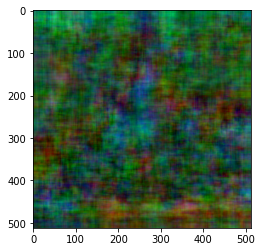

In [109]:
plt.imshow(out[0])

In [113]:
def make_stylizer(): # TODO: make work
    encoder = make_encoder()
    c_enc = encoder(c)
    s_enc = encoder(s)
    
    c4 = c_enc['enc_a']
    c5 = c_enc['enc_b']

    s4 = s_enc['enc_a']
    s5 = s_enc['enc_b']
    in_planes = [c4.shape[-1],c5.shape[-1]]
    transform = Transform_tf(in_planes=in_planes)
    tfm_cs = transform(c4,s4,c5,s5)

    decoder_planes = tfm_cs.shape[-1]
    decoder = make_decoder(decoder_planes)
    out = decoder(tfm_cs)
        
# stn = make_stylizer()

In [117]:
class Net_pt(nn.Module):
    pass

class Net_tf(tf.keras.Model):
    pass
